In [1]:
! gh issue list --repo expectedparrot/edsl --state open --limit 1000 --json number,title,state,createdAt,author,body,labels --jq '.[] | [.number, .title, .state, .createdAt, .author.login, (.labels | map(.name) | join(";")), .body] | @csv' > edsl_open_issues.csv

In [2]:
! gh issue list --repo expectedparrot/edsl --state open --limit 1000 --json number,title,state,createdAt,author,body,labels --jq '(["Number","Title","State","Created","Author","Labels","Body"] | @csv), (.[] | [.number, .title, .state, .createdAt, .author.login, (.labels | map(.name) | join(";")), .body] | @csv)' > edsl_open_issues.csv

In [3]:
from edsl import ScenarioList 
sl = ScenarioList.from_source("csv", "edsl_open_issues.csv")

In [4]:
sl[10]

,key,value
0,Number,1809
1,Title,Detect what causes large RAM memory usage (results + exeception task history) + add test scripts for this
2,State,OPEN
3,Created,2025-03-26T11:43:24Z
4,Author,zer0dss
5,Labels,enhancement
6,Body,


In [5]:
len(sl.filter("Labels == 'bug'"))

19

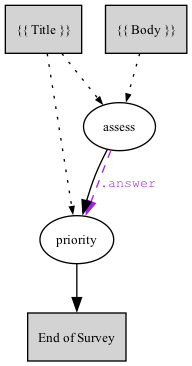

In [6]:
from edsl import QuestionFreeText, QuestionLinearScale, Survey
q_assess = QuestionFreeText(question_text = """The open-sourced package EDSL is a tool 
for doing AI-powered social science research. It has an open issue on github. The title is {{ Title }} 
and the description is {{ Body }}. Please write about how this issue could affect the user experience, 
focusing on ways it would degrade that experience and how severe it might be.
""", 
question_name = "assess")

q_score = QuestionLinearScale(question_text = """The open-sourced package EDSL is a tool 
for doing AI-powered social science research. It has an open issue on github. 
The impact of the issue: `{{ Title }}` on users was determined to be: {{ assess.answer }}. 
Please score this issue to help with prioritization.

About 20% of issues should be 1, 
About 30% of issues should be 2. 
About 50% of issues should be 3.
""",
        question_options = [1,2,3],
        option_labels = {
            1: "Tool is fundamentally unusable; affects security and safety",
            2: "Degrades user ability to do useful work; creates confusion",
            3: "An annoyance that will cause problems but users can mostly work around."},
        question_name = "priority")
survey = Survey([q_assess, q_score])
survey.show_flow()

In [7]:
results = survey.by(sl.filter("Labels == 'bug'")).run(verbose = False)

In [8]:
results.select("priority")

,answer.priority
0,2
1,2
2,2
3,2
4,2
5,2
6,2
7,2
8,2
9,2


In [9]:
from edsl import ScenarioList 
sl = ScenarioList.from_list('fruit', ['apple', 'cherry', 'banana', 'date', 'orange', "stink berry"])

In [10]:
sl.create_comparisons()

,option_1,option_2
0,{'fruit': 'apple'},{'fruit': 'cherry'}
1,{'fruit': 'apple'},{'fruit': 'banana'}
2,{'fruit': 'apple'},{'fruit': 'date'}
3,{'fruit': 'apple'},{'fruit': 'orange'}
4,{'fruit': 'apple'},{'fruit': 'stink berry'}
5,{'fruit': 'cherry'},{'fruit': 'banana'}
6,{'fruit': 'cherry'},{'fruit': 'date'}
7,{'fruit': 'cherry'},{'fruit': 'orange'}
8,{'fruit': 'cherry'},{'fruit': 'stink berry'}
9,{'fruit': 'banana'},{'fruit': 'date'}


In [11]:
from edsl import QuestionMultipleChoice
q = QuestionMultipleChoice(question_name = "fruit_pref", 
                           question_text = """Which fruit to you prefer: 
                           option_1: {{ scenario.option_1}}
                           option_2: {{ scenario.option_2}}?""",
                           question_options = ["option_1", "option_2"], 
                          )
results = q.by(sl.create_comparisons()).run(verbose = False)

In [12]:
results.select('fruit_pref', 'option_1', 'option_2')

,answer.fruit_pref,scenario.option_1,scenario.option_2
0,option_1,{'fruit': 'apple'},{'fruit': 'cherry'}
1,option_1,{'fruit': 'apple'},{'fruit': 'banana'}
2,option_1,{'fruit': 'apple'},{'fruit': 'date'}
3,option_1,{'fruit': 'apple'},{'fruit': 'orange'}
4,option_1,{'fruit': 'apple'},{'fruit': 'stink berry'}
5,option_2,{'fruit': 'cherry'},{'fruit': 'banana'}
6,option_1,{'fruit': 'cherry'},{'fruit': 'date'}
7,option_2,{'fruit': 'cherry'},{'fruit': 'orange'}
8,option_1,{'fruit': 'cherry'},{'fruit': 'stink berry'}
9,option_1,{'fruit': 'banana'},{'fruit': 'date'}


In [13]:
import itertools
from typing import List, Dict, Tuple, Any
from collections import defaultdict

def find_optimal_ranking(preferences: List[Dict[str, Any]]) -> Tuple[List[str], int]:
    """
    Find the optimal ranking with minimal transitivity violations from preference data.
    
    Parameters:
    -----------
    preferences : List[Dict[str, Any]]
        List of preference data. Each dictionary should have:
        - 'options': List of options presented (strings)
        - 'chosen': The chosen option (string)
        
    Returns:
    --------
    Tuple[List[str], int]
        A tuple containing:
        - The optimal ranking as a list (most preferred to least preferred)
        - The number of transitivity violations in this ranking
    """
    # Extract all unique items
    all_items = set()
    
    # Build pairwise comparisons from the preferences
    comparisons = []
    for pref in preferences:
        options = pref['options']
        chosen = pref['chosen']
        
        if chosen not in options:
            raise ValueError(f"Chosen option '{chosen}' not in available options: {options}")
            
        # Add all items to our set
        all_items.update(options)
        
        # Create pairwise comparisons: chosen > each other option
        for option in options:
            if option != chosen:
                comparisons.append((chosen, option))  # chosen is preferred over option
    
    # Convert set to list for consistent ordering
    all_items = list(all_items)
    
    # Build a directed graph of preferences
    graph = {item: {'wins': 0, 'losses': 0, 'against': defaultdict(int)} for item in all_items}
    
    for winner, loser in comparisons:
        graph[winner]['wins'] += 1
        graph[loser]['losses'] += 1
        graph[winner]['against'][loser] += 1
    
    # Calculate win percentages
    for item in graph:
        total_games = graph[item]['wins'] + graph[item]['losses']
        graph[item]['win_pct'] = graph[item]['wins'] / total_games if total_games > 0 else 0
    
    # Function to count transitivity violations for a given ranking
    def count_violations(ranking: List[str]) -> int:
        violations = 0
        for i in range(len(ranking)):
            for j in range(i + 1, len(ranking)):
                higher_ranked = ranking[i]
                lower_ranked = ranking[j]
                
                # Check if lower-ranked beat higher-ranked item
                if graph[lower_ranked]['against'][higher_ranked] > 0:
                    violations += graph[lower_ranked]['against'][higher_ranked]
        
        return violations
    
    # For a small number of items, try all permutations
    if len(all_items) <= 8:  # Limit for performance reasons (8! = 40,320 permutations)
        best_ranking = None
        min_violations = float('inf')
        
        for perm in itertools.permutations(all_items):
            violations = count_violations(perm)
            if violations < min_violations:
                min_violations = violations
                best_ranking = list(perm)
        
        return best_ranking, min_violations
    
    # For larger sets, use heuristic rankings and pick the best
    heuristic_rankings = [
        # By win percentage
        sorted(all_items, key=lambda x: graph[x]['win_pct'], reverse=True),
        # By total wins
        sorted(all_items, key=lambda x: graph[x]['wins'], reverse=True),
        # By net wins (wins - losses)
        sorted(all_items, key=lambda x: graph[x]['wins'] - graph[x]['losses'], reverse=True)
    ]
    
    best_ranking = None
    min_violations = float('inf')
    
    for ranking in heuristic_rankings:
        violations = count_violations(ranking)
        if violations < min_violations:
            min_violations = violations
            best_ranking = ranking
    
    return best_ranking, min_violations


def convert_pairwise_to_preferences(pairwise_data: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Convert pairwise comparison data to the standard preference format.
    
    Parameters:
    -----------
    pairwise_data : List[Dict[str, Any]]
        List of pairwise comparison data. Each dictionary should have:
        - 'option1': First option
        - 'option2': Second option
        - 'choice': Either 'option1' or 'option2' indicating which was chosen
        
    Returns:
    --------
    List[Dict[str, Any]]
        Preference data in the standard format for find_optimal_ranking
    """
    preferences = []
    
    for pair in pairwise_data:
        option1 = pair['option1']
        option2 = pair['option2']
        choice = pair['choice']
        
        chosen = option1 if choice == 'option1' else option2
        
        preferences.append({
            'options': [option1, option2],
            'chosen': chosen
        })
    
    return preferences


def convert_ranked_to_preferences(ranked_data: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Convert ranked list data to the standard preference format.
    
    Parameters:
    -----------
    ranked_data : List[Dict[str, Any]]
        List of ranked data. Each dictionary should have:
        - 'options': List of options presented
        - 'ranking': List of options in ranked order (most to least preferred)
        
    Returns:
    --------
    List[Dict[str, Any]]
        Preference data in the standard format for find_optimal_ranking
    """
    preferences = []
    
    for rank_data in ranked_data:
        options = rank_data['options']
        ranking = rank_data['ranking']
        
        # Generate all pairwise preferences from the ranking
        for i in range(len(ranking)):
            preferred = ranking[i]
            
            for j in range(i + 1, len(ranking)):
                less_preferred = ranking[j]
                
                # Only include if both items were in the original options
                if preferred in options and less_preferred in options:
                    preferences.append({
                        'options': [preferred, less_preferred],
                        'chosen': preferred
                    })
    
    return preferences


def convert_pandas_df_to_preferences(df, 
                              pref_col='answer.fruit_pref', 
                              option1_col='scenario.option_1', 
                              option2_col='scenario.option_2'):
    """
    Convert a pandas DataFrame with preference data to the standard preference format.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing preference data
    pref_col : str
        Column name that indicates which option was chosen (e.g., 'answer.fruit_pref')
    option1_col : str
        Column name for the first option (e.g., 'scenario.option_1')
    option2_col : str
        Column name for the second option (e.g., 'scenario.option_2')
        
    Returns:
    --------
    List[Dict[str, Any]]
        Preference data in the standard format for find_optimal_ranking
    """
    preferences = []
    
    for _, row in df.iterrows():
        # Extract option values
        option1_val = extract_value_from_dict_str(row[option1_col])
        option2_val = extract_value_from_dict_str(row[option2_col])
        
        # Determine which option was chosen
        chosen = option1_val if row[pref_col] == 'option_1' else option2_val
        
        preferences.append({
            'options': [option1_val, option2_val],
            'chosen': chosen
        })
    
    return preferences


def extract_value_from_dict_str(dict_str):
    """
    Extract value from a dictionary-like string such as "{'fruit': 'apple'}"
    
    Parameters:
    -----------
    dict_str : str or dict
        Dictionary-like string or actual dictionary
        
    Returns:
    --------
    str
        The extracted value
    """
    # If it's already a dictionary
    if isinstance(dict_str, dict):
        if 'fruit' in dict_str:
            return dict_str['fruit']
        return next(iter(dict_str.values()))  # Return first value
    
    # If it's a string representation of a dictionary
    if isinstance(dict_str, str) and "'" in dict_str:
        # Simple parsing for common format {'key': 'value'}
        parts = dict_str.split("'")
        if len(parts) >= 4:
            return parts[3]  # This should be the value
    
    # If all else fails, return as is
    return dict_str


# Example usage
if __name__ == "__main__":
    
    
    df = results.select('fruit_pref', 'option_1', 'option_2').to_pandas()
    preferences = convert_pandas_df_to_preferences(df)
    
    # Find optimal ranking
    optimal_ranking, violations = find_optimal_ranking(preferences)
    print(f"Optimal ranking from pandas DataFrame: {optimal_ranking}")
    print(f"Number of transitivity violations: {violations}")


Optimal ranking from pandas DataFrame: ['apple', 'orange', 'banana', 'cherry', 'date', 'stink berry']
Number of transitivity violations: 0


In [14]:
from edsl import Notebook
nb = Notebook(path = "PairwiseComparisonsDemo.ipynb")

In [15]:
if refresh := False:
    nb.push(visibility = "public", 
        alias = "pairwise-comparisons", 
        description = "Turn scenario into pariwise comparisons")
else:
    nb.patch('8d67b02d-06db-41f2-ac0d-87249e66a0d3')

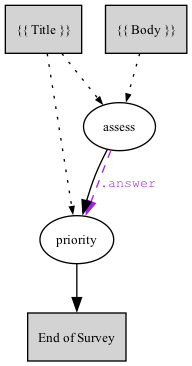

In [16]:
survey.show_flow()